In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

import sys 
sys.path.insert(1, '/media3/etienne/workdir/spark_AGN/Build_classifier')
import classifier_tools as ct


In [14]:
balanced = True

name_1 = 'ELASTICC_TRAIN_SNIa-SALT2_bazin_cut_features'
name_2 = 'ELASTICC_TRAIN_SNIb+HostXT_V19_bazin_cut_features'


main_file = 'bazin_features'

features_1 = pd.read_parquet(f'{main_file}/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'{main_file}/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    nobj = min(len(features_1), len(features_2))
    bazin_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    bazin_features = pd.concat([features_1, features_2])


main_file = 'features'

features_1 = pd.read_parquet(f'{main_file}/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'{main_file}/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    kostya_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    kostya_features = pd.concat([features_1, features_2])

Bazin : Accuracy on testing sample is : 88.06%
Efficiency : 89.09% of real Ia were labeled as Ia
Purity : 87.42% of classified Ia were indeed Ia


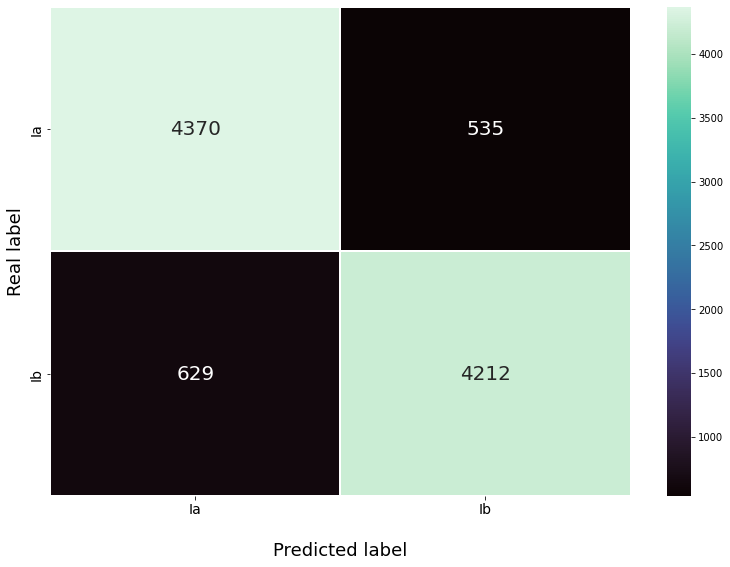

Kostya : Accuracy on testing sample is : 89.58%
Efficiency : 90.91% of real Ia were labeled as Ia
Purity : 88.67% of classified Ia were indeed Ia


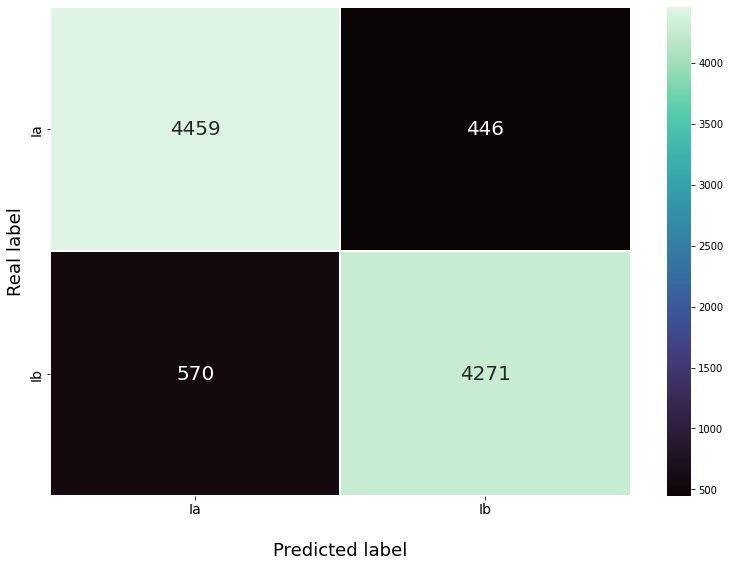

In [15]:
seed = 42
methods = [[bazin_features, 'Bazin'], [kostya_features, 'Kostya']]


rf = {}

for features in methods:
    
    X_train, X_test, y_train, y_test = train_test_split(features[0].iloc[:,:-1], features[0]['target'], test_size=0.5, random_state=seed)
    clf = RandomForestClassifier(n_estimators = 100, random_state=seed)
    clf.fit(X_train, y_train)
    
    rf[features[1]] = clf

    score = clf.score(X_test, y_test)
    print(f'{features[1]} : Accuracy on testing sample is : {score*100:.2f}%')
    ct.draw_confusion(clf, X_test, y_test, interest='Ia')

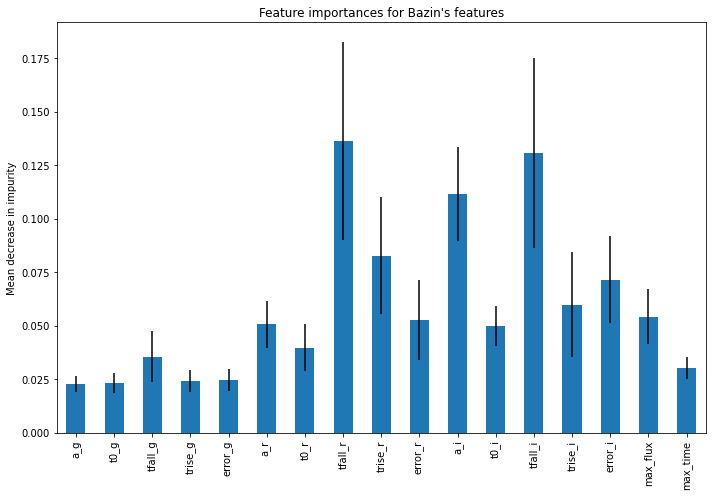

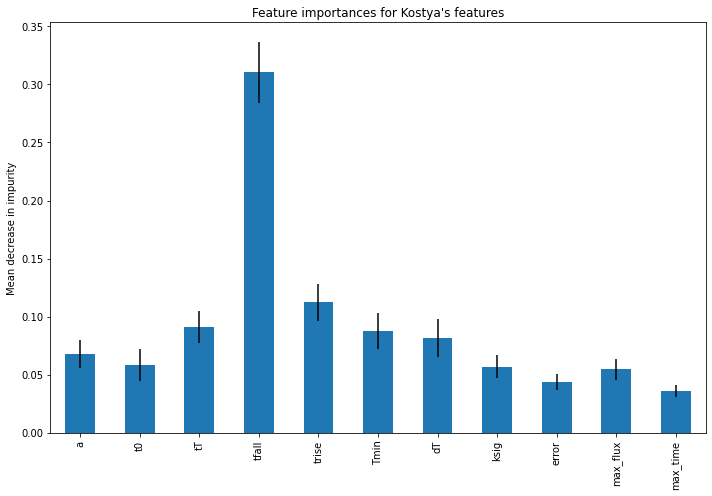

In [16]:
for idx, features in enumerate(methods):
    
    importances = rf[features[1]].feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf[features[1]].estimators_], axis=0)

    forest_importances = pd.Series(importances, index=features[0].iloc[:, :-1].keys())
    fig, ax = plt.subplots(figsize = (10, 7))


    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Feature importances for {features[1]}'s features")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()